# Analysis of the Influence of Affective Ratings for English Vocabulary Items on the Lexical Retrieval in Chinese

This project has the objective to find out whether the retrieval time of lexical items in Chinese, influenced by the complexity of characters (Tsang 2018), is additionally influenced by affective ratings (arousal, dominance and valence) for English vocabulary items, as compiled by Mohammad (2018), riskily assuming that these ratings will transfer interculturally.

This project is an adaptation of a project done by me as an assignment for the Data Science for Linguists advanced seminar taught in the Winter Semester 2024/25 at the University of Tübingen.

Importing the required modules

In [88]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, SGDRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Section I: Joining the Datasets

First, I load the .tsv datasets to separate data frames

In [89]:
affective_ratings = pd.read_csv("ChineseRetrievalAnalysis/cmn-opensubtitles-freq.tsv", sep="\t")
lexical_decision = pd.read_csv("ChineseRetrievalAnalysis/cmn-opensubtitles-freq.tsvTsang-2018-LexicalDecision.tsv", sep="\t")

Displaying the data frames heads

In [90]:
affective_ratings.head()

,CONCEPTICON_ID,CONCEPTICON_GLOSS,ENGLISH,ENGLISH_VALENCE_MEAN,ENGLISH_AROUSAL_MEAN,ENGLISH_DOMINANCE_MEAN,LINE_IN_SOURCE
0,1,CONTEMPTIBLE,contemptible,0.146,0.657,0.471,3743
1,10,FIREWOOD,firewood,0.520,0.348,0.263,6736
2,100,FAITHFUL,faithful,0.888,0.333,0.627,6437
3,1000,ANXIETY,anxiety,0.146,0.865,0.342,777
4,1001,BLACKSMITH,blacksmith,0.480,0.531,0.702,1785


In [91]:
lexical_decision.head()

,CONCEPTICON_ID,CONCEPTICON_GLOSS,CHINESE,CHINESE_RT_MEAN,CHINESE_RT_ZSCORE,CHINESE_STROKE,LINE_IN_SOURCE
0,10,FIREWOOD,柴火,741.216250,-0.295747,14.0,7792
1,1001,BLACKSMITH,铁匠,678.218095,-0.516459,16.0,8258
2,1002,STATUE,雕像,704.751000,-0.464274,29.0,10389
3,1003,PERMIT,允许,654.635500,-0.663564,10.0,2482
4,1004,MUSCLE,肌肉,669.430500,-0.558841,12.0,4721


Now I'm merging the data by the `CONCEPTION_ID` column and filtering to include only rows where data exists in both datasets. Doing the inner join.

In [92]:
merged_data = pd.merge(affective_ratings, lexical_decision, on="CONCEPTICON_ID", how="inner")

Again displaying the head

In [93]:
merged_data.head()

,CONCEPTICON_ID,CONCEPTICON_GLOSS_x,ENGLISH,ENGLISH_VALENCE_MEAN,ENGLISH_AROUSAL_MEAN,ENGLISH_DOMINANCE_MEAN,LINE_IN_SOURCE_x,CONCEPTICON_GLOSS_y,CHINESE,CHINESE_RT_MEAN,CHINESE_RT_ZSCORE,CHINESE_STROKE,LINE_IN_SOURCE_y
0,10,FIREWOOD,firewood,0.520,0.348,0.263,6736,FIREWOOD,柴火,741.216250,-0.295747,14.0,7792
1,1001,BLACKSMITH,blacksmith,0.480,0.531,0.702,1785,BLACKSMITH,铁匠,678.218095,-0.516459,16.0,8258
2,1002,STATUE,statue,0.542,0.153,0.570,16845,STATUE,雕像,704.751000,-0.464274,29.0,10389
3,1003,PERMIT,allow,0.698,0.429,0.538,518,PERMIT,允许,654.635500,-0.663564,10.0,2482
4,1004,MUSCLE,muscle,0.359,0.490,0.645,11503,MUSCLE,肌肉,669.430500,-0.558841,12.0,4721


# Section II: Arousal and Reaction Times by Number of Strokes
## a) Grouping the data

I group the data by the number of Chinese strokes and aggregate the means

In [95]:
grouped_data = merged_data.groupby("CHINESE_STROKE").agg({
    "ENGLISH_AROUSAL_MEAN": "mean",
    "CHINESE_RT_MEAN": "mean"
}).reset_index()

Displaying the head

In [96]:
grouped_data.head()

,CHINESE_STROKE,ENGLISH_AROUSAL_MEAN,CHINESE_RT_MEAN
0,3.0,0.306500,659.623373
1,4.0,0.363444,692.974473
2,5.0,0.448556,657.017944
3,6.0,0.486000,711.511801
4,7.0,0.489280,674.809692


## b) Scaling by a factor and plotting

I scale the English arousal values in the data by the factor of 1000

In [97]:
grouped_data["SCALED_ENGLISH_AROUSAL_MEAN"] = grouped_data["ENGLISH_AROUSAL_MEAN"] * 1000

Displaying modified data

In [98]:
grouped_data.head()

,CHINESE_STROKE,ENGLISH_AROUSAL_MEAN,CHINESE_RT_MEAN,SCALED_ENGLISH_AROUSAL_MEAN
0,3.0,0.306500,659.623373,306.500000
1,4.0,0.363444,692.974473,363.444444
2,5.0,0.448556,657.017944,448.555556
3,6.0,0.486000,711.511801,486.000000
4,7.0,0.489280,674.809692,489.280000


Let's plot!

For Seaborn, a long-form data frame has to be created

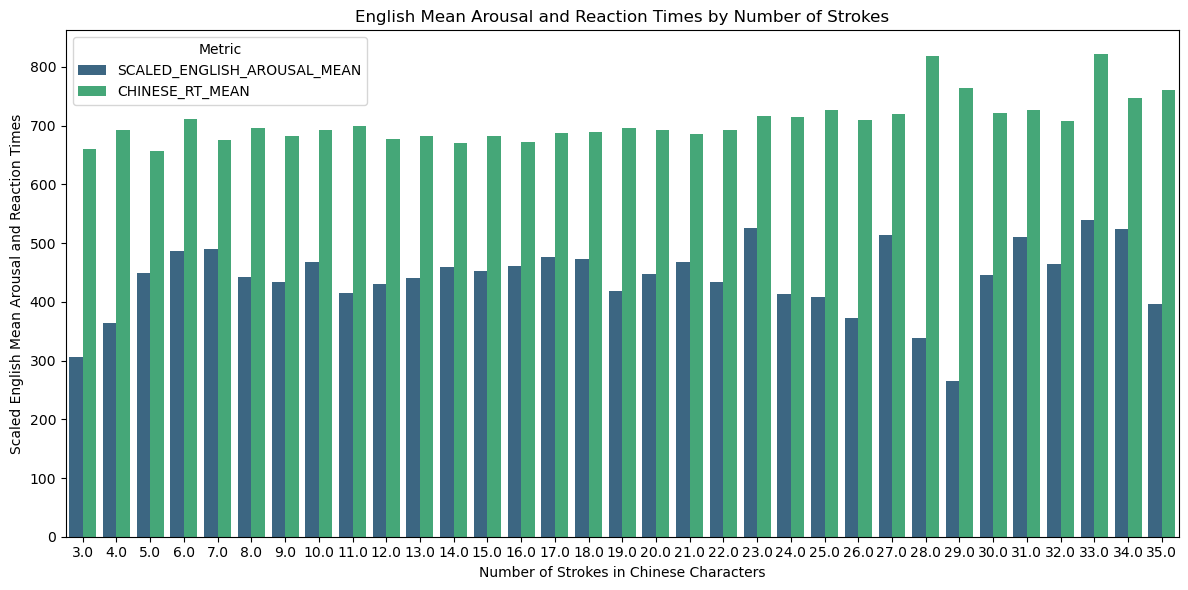

In [99]:
plt.figure(figsize=(12, 6))

plot_data = grouped_data.melt(
    id_vars="CHINESE_STROKE", 
    value_vars=["SCALED_ENGLISH_AROUSAL_MEAN", "CHINESE_RT_MEAN"], 
    var_name="Metric", 
    value_name="Value"
)

sns.barplot(
    data=plot_data, 
    x="CHINESE_STROKE", 
    y="Value", 
    hue="Metric", 
    palette='viridis'
)

plt.xlabel("Number of Strokes in Chinese Characters")
plt.ylabel("Scaled English Mean Arousal and Reaction Times")
plt.title("English Mean Arousal and Reaction Times by Number of Strokes")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

The connection between stroke count and lexical retrieval times is not immediately obvious. The affective ratings data looks like as if it could provide independent evidence

# Section III: Further Exploratory Data Analysis

### Joint plot for Chinese reaction times vs stroke count

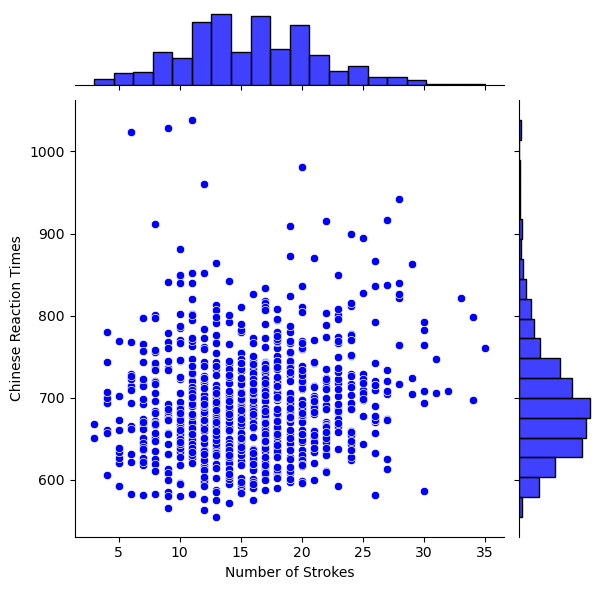

In [100]:
sns.jointplot(
    data=merged_data, 
    x='CHINESE_STROKE', 
    y='CHINESE_RT_MEAN', 
    kind='scatter', 
    marginal_kws=dict(bins=20, fill=True), 
    color='blue'
).set_axis_labels("Number of Strokes", "Chinese Reaction Times")

plt.show()

Chinese reaction times seem to be very unpredictable based on the number of strokes.

### Joint plot for Chinese reaction times vs English arousal

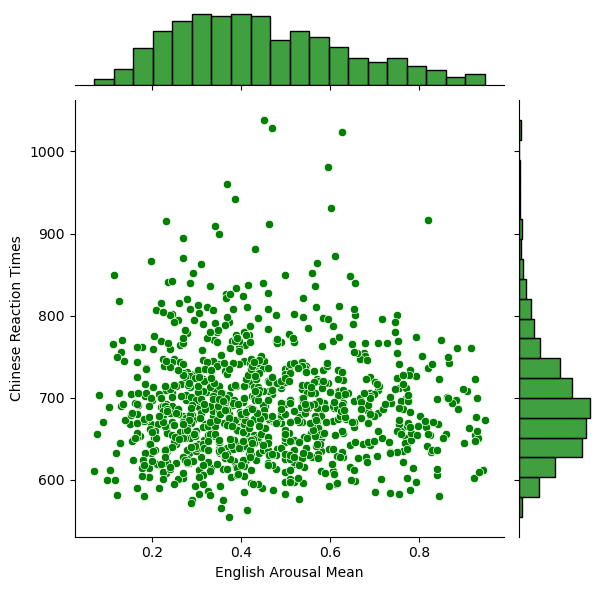

In [101]:
sns.jointplot(
    data=merged_data, 
    x='ENGLISH_AROUSAL_MEAN', 
    y='CHINESE_RT_MEAN', 
    kind='scatter', 
    marginal_kws=dict(bins=20, fill=True), 
    color='green'
).set_axis_labels("English Arousal Mean", "Chinese Reaction Times")

plt.show()

There is a steady, linear growth of Chinese reaction time with the growth of the arousal until the mean arousal of ca. 0.3. Then, until the mean arousal of ca. 0.5, the reaction time remains constant, after that, it falls again, but at a slower rate than it grows at the beginning.

### Joint plot for Chinese reaction times vs English dominance

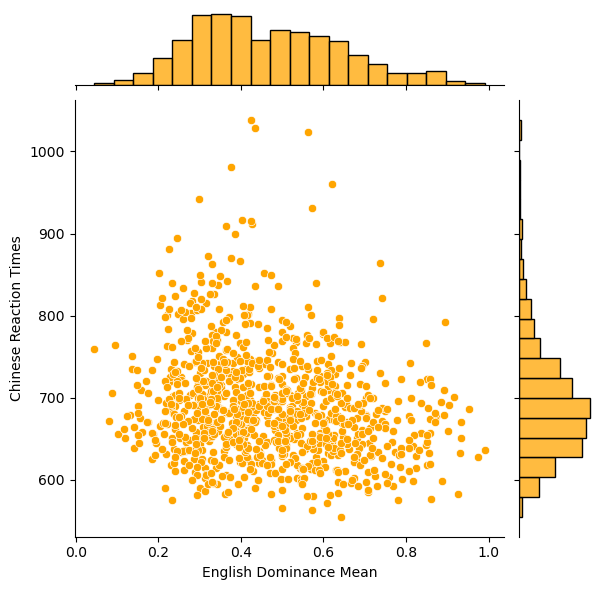

In [102]:
sns.jointplot(
    data=merged_data, 
    x='ENGLISH_DOMINANCE_MEAN', 
    y='CHINESE_RT_MEAN', 
    kind='scatter', 
    marginal_kws=dict(bins=20, fill=True), 
    color='orange'
).set_axis_labels("English Dominance Mean", "Chinese Reaction Times")

plt.show()

Similar case as with the previous plot.

### Joint plot for Chinese reaction times vs English valence

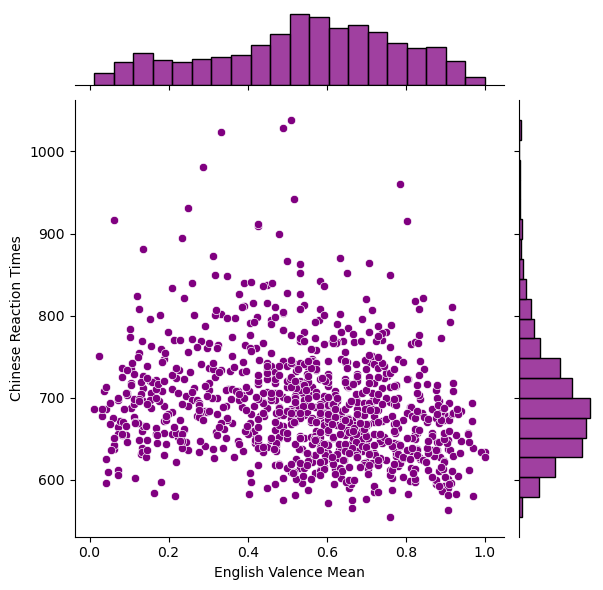

In [103]:
sns.jointplot(
    data=merged_data, 
    x='ENGLISH_VALENCE_MEAN', 
    y='CHINESE_RT_MEAN', 
    kind='scatter', 
    marginal_kws=dict(bins=20, fill=True), 
    color='purple'
).set_axis_labels("English Valence Mean", "Chinese Reaction Times")

plt.show()

There seems to be a slight negative correlation between the English valence mean and Chinese reaction times. Chinese reaction times drop insignificantly with the growth of the English valence mean.

# Section IV: Bringing Frequencies into the Picture
## a) Adding `cmn-opensubtitles-freq.tsv`

In [104]:
frequency_data = pd.read_csv("C:\\Users\\Szymon\\Documents\\TYBINGA\\WiSe 2024-25\\DATSCILING\\As06\\cmn-opensubtitles-freq.tsv", sep="\t", names=["CHINESE", "RAW_FREQUENCY"])

Displaying the head

In [105]:
frequency_data.head()

,CHINESE,RAW_FREQUENCY
0,的,3957141
1,我,3669472
2,你,3282942
3,了,2141739
4,是,1670639


Transforming raw frequencies to log frequencies

In [106]:
frequency_data["LOG_FREQUENCY"] = np.log1p(frequency_data["RAW_FREQUENCY"])

Displaying the head

In [107]:
frequency_data.head()

,CHINESE,RAW_FREQUENCY,LOG_FREQUENCY
0,的,3957141,15.191033
1,我,3669472,15.115559
2,你,3282942,15.004251
3,了,2141739,14.577129
4,是,1670639,14.328717


Merging

In [108]:
merged_data_with_frequency = pd.merge(merged_data, frequency_data, on="CHINESE", how="inner")

Displaying the head

In [109]:
merged_data_with_frequency.head()

,CONCEPTICON_ID,CONCEPTICON_GLOSS_x,ENGLISH,ENGLISH_VALENCE_MEAN,ENGLISH_AROUSAL_MEAN,ENGLISH_DOMINANCE_MEAN,LINE_IN_SOURCE_x,CONCEPTICON_GLOSS_y,CHINESE,CHINESE_RT_MEAN,CHINESE_RT_ZSCORE,CHINESE_STROKE,LINE_IN_SOURCE_y,RAW_FREQUENCY,LOG_FREQUENCY
0,10,FIREWOOD,firewood,0.520,0.348,0.263,6736,FIREWOOD,柴火,741.216250,-0.295747,14.0,7792,166,5.117994
1,1001,BLACKSMITH,blacksmith,0.480,0.531,0.702,1785,BLACKSMITH,铁匠,678.218095,-0.516459,16.0,8258,191,5.257495
2,1002,STATUE,statue,0.542,0.153,0.570,16845,STATUE,雕像,704.751000,-0.464274,29.0,10389,957,6.864848
3,1003,PERMIT,allow,0.698,0.429,0.538,518,PERMIT,允许,654.635500,-0.663564,10.0,2482,6262,8.742415
4,1004,MUSCLE,muscle,0.359,0.490,0.645,11503,MUSCLE,肌肉,669.430500,-0.558841,12.0,4721,1659,7.414573


## b) Plotting

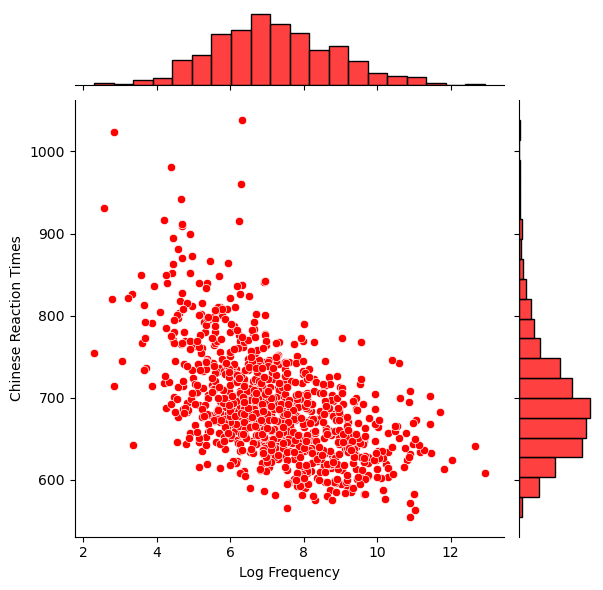

In [110]:
sns.jointplot(
    data=merged_data_with_frequency, 
    x='LOG_FREQUENCY', 
    y='CHINESE_RT_MEAN', 
    kind='scatter', 
    marginal_kws=dict(bins=20, fill=True), 
    color='red'
).set_axis_labels("Log Frequency", "Chinese Reaction Times")

plt.show()

There is obvious negative correlation: as the log frequency grows, the reaction time decreases. It might be connected to the fact that less frequent words are more characteristic and invoke faster reaction.

# Section V: Fitting Regression Models in Scikit-Learn

## a) Filtering out incomplete data
To filter out incomplete data, I use the `dropna` method from pandas.

In [111]:
filtered_data = merged_data_with_frequency.dropna(subset=[
    "CHINESE_RT_MEAN", 
    "ENGLISH_DOMINANCE_MEAN", 
    "ENGLISH_VALENCE_MEAN", 
    "ENGLISH_AROUSAL_MEAN", 
    "CHINESE_STROKE", 
    "LOG_FREQUENCY"
])

Displaying the head

In [112]:
filtered_data.head()

,CONCEPTICON_ID,CONCEPTICON_GLOSS_x,ENGLISH,ENGLISH_VALENCE_MEAN,ENGLISH_AROUSAL_MEAN,ENGLISH_DOMINANCE_MEAN,LINE_IN_SOURCE_x,CONCEPTICON_GLOSS_y,CHINESE,CHINESE_RT_MEAN,CHINESE_RT_ZSCORE,CHINESE_STROKE,LINE_IN_SOURCE_y,RAW_FREQUENCY,LOG_FREQUENCY
0,10,FIREWOOD,firewood,0.520,0.348,0.263,6736,FIREWOOD,柴火,741.216250,-0.295747,14.0,7792,166,5.117994
1,1001,BLACKSMITH,blacksmith,0.480,0.531,0.702,1785,BLACKSMITH,铁匠,678.218095,-0.516459,16.0,8258,191,5.257495
2,1002,STATUE,statue,0.542,0.153,0.570,16845,STATUE,雕像,704.751000,-0.464274,29.0,10389,957,6.864848
3,1003,PERMIT,allow,0.698,0.429,0.538,518,PERMIT,允许,654.635500,-0.663564,10.0,2482,6262,8.742415
4,1004,MUSCLE,muscle,0.359,0.490,0.645,11503,MUSCLE,肌肉,669.430500,-0.558841,12.0,4721,1659,7.414573


Asserting the length

In [113]:
print(len(filtered_data) == 955)

True


## b) Experiments with the data

Preparing the data for regression

In [114]:
X = filtered_data[[
    "ENGLISH_DOMINANCE_MEAN", 
    "ENGLISH_VALENCE_MEAN", 
    "ENGLISH_AROUSAL_MEAN", 
    "CHINESE_STROKE", 
    "LOG_FREQUENCY"
]]
y = filtered_data['CHINESE_RT_MEAN']

Splitting the data into 2 sets: training and testing

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Initialising the models

In [116]:
models = {
    "LinearRegression": LinearRegression(),
    "RidgeCV": RidgeCV(),
    "LassoCV": LassoCV(cv=5),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "SVR": SVR()
}

Fitting the models and testing

In [117]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = {"R²": r2, "MSE": mse}

Getting the results

In [118]:
for model_name, metrics in results.items():
    print(f"{model_name} -> R²: {metrics['R²']:.4f}, MSE: {metrics['MSE']:.4f}")

LinearRegression -> R²: 0.1812, MSE: 2785.8691
RidgeCV -> R²: 0.1848, MSE: 2773.8532
LassoCV -> R²: 0.1821, MSE: 2782.8603
SGDRegressor -> R²: -0.1229, MSE: 3820.7814
SVR -> R²: 0.0870, MSE: 3106.3423


The best model at predicting reaction time based on dominance, valence, arousal, stroke count, and log frequency is the RidgeCV model. It has the highest R-squared score and the lowest MSE score. However, none of the models does particularly well at explaining the variation.

# Section VI: Model Selection
## a) Fitting linear models

Defining predictors and target variable

In [119]:
predictors = ["ENGLISH_DOMINANCE_MEAN", "ENGLISH_VALENCE_MEAN", "ENGLISH_AROUSAL_MEAN", "CHINESE_STROKE", "LOG_FREQUENCY"]
target = "CHINESE_RT_MEAN"

Preparing the data

In [120]:
filtered_data = merged_data_with_frequency.dropna(subset=predictors + [target])
X = filtered_data[predictors]
Y = filtered_data[target]

Using the best model as found in section 5

In [121]:
best_model = RidgeCV()

In [122]:
best_subset_models = {}
cv = KFold(n_splits=10, shuffle=True, random_state=42)

Iteration for each number k of predictor variables to fit linear models

In [123]:
for k in range(1, len(predictors) + 1):
    best_r2 = -np.inf
    best_subset = None
    best_model_instance = None

    for subset in combinations(predictors, k):
        X_subset = X[list(subset)]
        model = RidgeCV()
        scores = cross_val_score(model, X_subset, Y, cv=cv, scoring='r2')
        mean_r2 = np.mean(scores)
        
        if mean_r2 > best_r2:
            best_r2 = mean_r2
            best_subset = subset
            best_model_instance = model
    
    best_subset_models[k] = (best_subset, best_model_instance, best_r2)

## b) Selecting the best model using cross-validation

In [124]:
best_k = max(best_subset_models, key=lambda k: best_subset_models[k][2])
selected_model = best_subset_models[best_k]

Finding the best model

In [125]:
print(f"Best Model uses {best_k} predictors: {selected_model[0]} with R² score: {selected_model[2]:.4f}")

Best Model uses 4 predictors: ('ENGLISH_DOMINANCE_MEAN', 'ENGLISH_VALENCE_MEAN', 'CHINESE_STROKE', 'LOG_FREQUENCY') with R² score: 0.2916


R² score of the best model means that the selected predictors explain only around 29% of the variance. This means that other, unaccounted factors might play a role. Not selecting arousal can mean that the valence and dominance are stronger predictors and that emotionally charged words exercise greater influence over the time of the lexical retrieval. Stroke count, accounting for the visual complexity of chinese word, also influences the retrieval time: the more complex the character is, the more time it takes to process it, hence lengthening of the retrieval time. However, based on the R² score, we should suppose that there are other important factors contributing to the retrieval time.